In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import data_utils as du
import plotters
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.statistics import check_seasonality,plot_acf,plot_pacf,remove_seasonality,remove_trend,stationarity_test_adf
from darts.utils.statistics import extract_trend_and_seasonality
import os
from meteostat import Point, Hourly
import holidays
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
day_price_df = pd.read_csv('./data/Day-ahead_Prices_60min.csv')

day_price_df[['start_time', 'end_time']] = day_price_df['MTU (CET/CEST)']\
                                                .str.split(' - ', expand=True)
day_price_df.drop(columns=['MTU (CET/CEST)', 'BZN|DE-LU', 'Currency', 'end_time']
                , inplace=True) # assumes all currency same in same region
day_price_df.rename(columns={
    'Day-ahead Price [EUR/MWh]': 'price'
}, inplace=True)

day_price_df['start_time'] = pd.to_datetime(day_price_df['start_time'], format='%d.%m.%Y %H:%M')
day_price_ts = day_price_df.set_index('start_time') 

day_price_df[day_price_df['price'].isna()]

# Use the function
missing_row = du.show_nrows_around_nan(day_price_df, 'price', 5)


NaN at index 2042:
       price          start_time
2037  244.98 2022-03-26 21:00:00
2038  244.94 2022-03-26 22:00:00
2039  237.75 2022-03-26 23:00:00
2040  235.00 2022-03-27 00:00:00
2041  221.93 2022-03-27 01:00:00
2042     NaN 2022-03-27 02:00:00
2043  214.02 2022-03-27 03:00:00
2044  212.00 2022-03-27 04:00:00
2045  211.09 2022-03-27 05:00:00
2046  210.31 2022-03-27 06:00:00
2047  214.03 2022-03-27 07:00:00
----------------------------------------


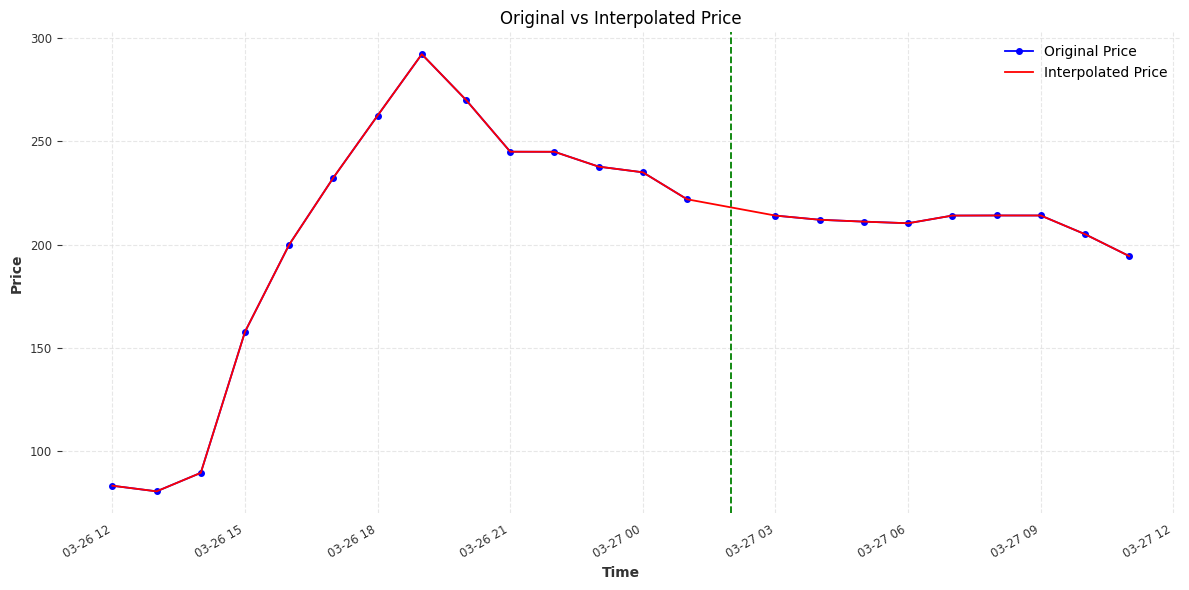

In [3]:
day_price_ts['price_interpolated'] = day_price_ts['price'].interpolate(method='time')

# Analysis
start_date = datetime(2022, 3, 26, 12)
end_date = datetime(2022, 3, 27, 12)
filtered_data = day_price_ts[['price', 'price_interpolated']].loc[
    (day_price_ts.index >= start_date) & (day_price_ts.index < end_date)
]
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['price'], 'b-o', label='Original Price', markersize=4)
plt.plot(filtered_data.index, filtered_data['price_interpolated'], 'r-', label='Interpolated Price')
plt.title('Original vs Interpolated Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

vertical_line_time = datetime(2022, 3, 27, 2)  # Time for the vertical line
plt.axvline(x=vertical_line_time, color='green', linestyle='--', label='02:00')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show();

In [4]:
day_price_ts['price'] = day_price_ts['price_interpolated']
day_price_ts = day_price_ts.drop(columns=['price_interpolated'])

<Axes: xlabel='start_time'>

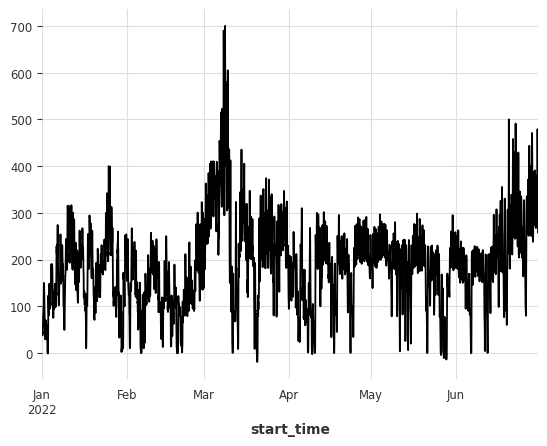

In [5]:
day_price_ts['price'].plot()

In [6]:
day_price_ts = du.add_date_features(day_price_ts)


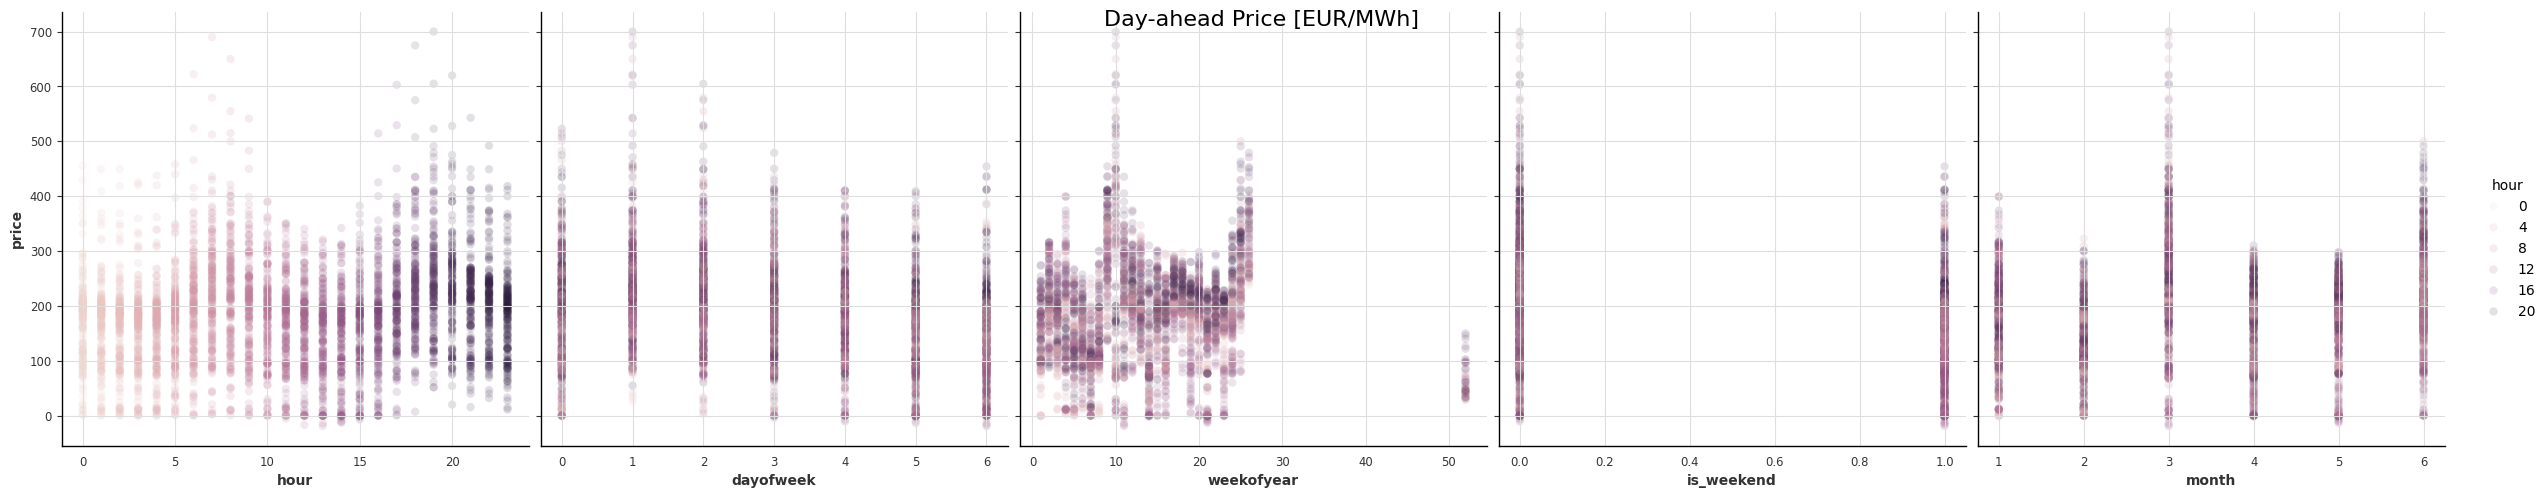

In [7]:
sns.pairplot(day_price_ts,
            hue='hour',
            x_vars=['hour','dayofweek','weekofyear', 'is_weekend', 'month'],
            y_vars='price',
            height=5,
            plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Day-ahead Price [EUR/MWh]', fontsize=16)
plt.show()

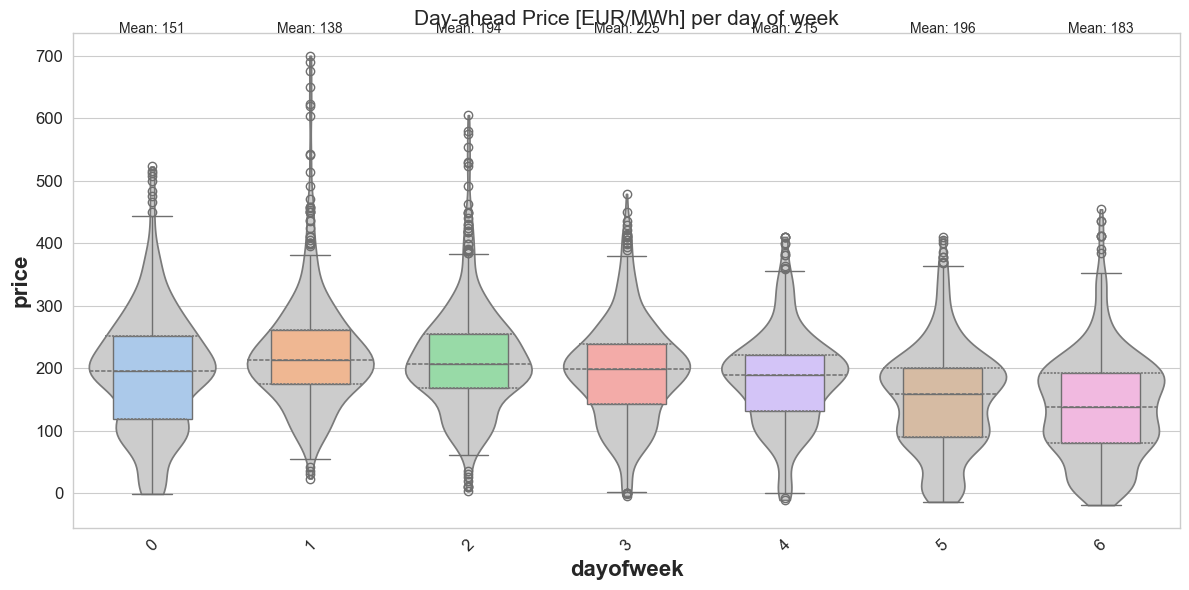

In [8]:
plotters.plot_violin_ts(day_price_ts, 'dayofweek', 'price', 'Day-ahead Price [EUR/MWh] per day of week')

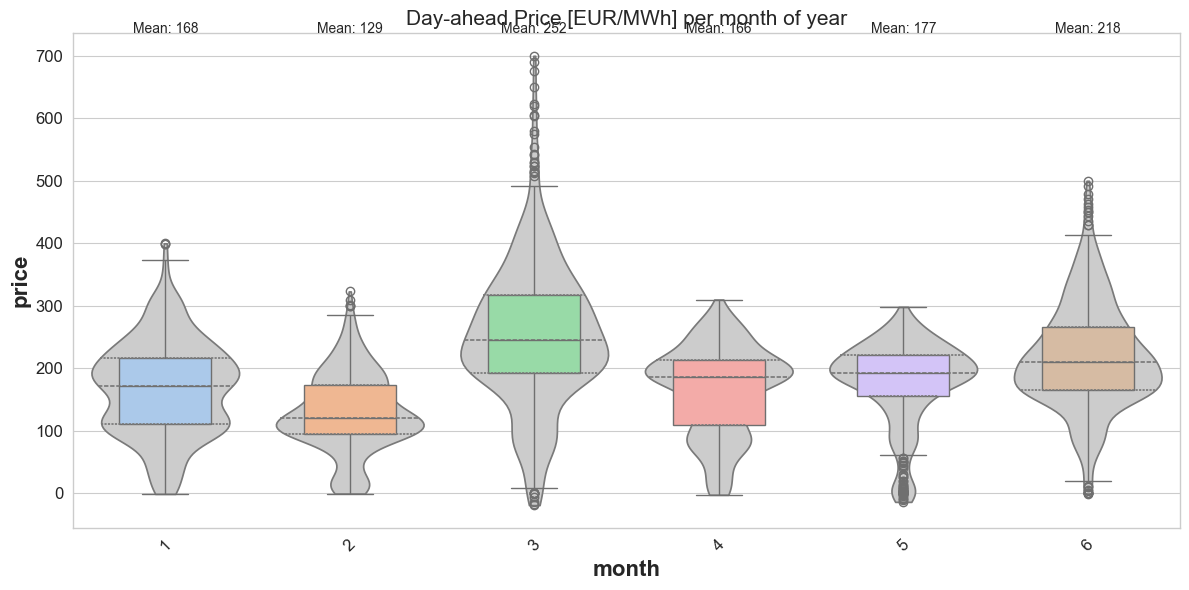

In [9]:
plotters.plot_violin_ts(day_price_ts, 'month', 'price', 'Day-ahead Price [EUR/MWh] per month of year')

### Add temperature

In [10]:
locations = {
    'LU': (49.815273, 6.129583),  # Luxembourg City coordinates
    'DE': (52.520008, 13.404954)  # Berlin coordinates (as an example for Germany)
}

weather_data = du.add_locations_weather(day_price_ts, locations)

In [11]:
merged_data = day_price_ts.merge(weather_data[['temp', 'tsun']], left_index=True, right_index=True, how='left')


In [12]:
merged_data

,price,is_weekend,datetime,hour,dayofweek,quarter,year,dayofyear,dayofmonth,month,weekofyear,temp,tsun
start_time,,,,,,,,,,,,,
2022-01-01 00:00:00,50.05,True,2022-01-01 00:00:00,0,5,1,2022,1,1,1,52,11.9,0.0
2022-01-01 01:00:00,41.33,True,2022-01-01 01:00:00,1,5,1,2022,1,1,1,52,11.9,0.0
2022-01-01 02:00:00,43.22,True,2022-01-01 02:00:00,2,5,1,2022,1,1,1,52,11.9,0.0
2022-01-01 03:00:00,45.46,True,2022-01-01 03:00:00,3,5,1,2022,1,1,1,52,11.9,0.0
2022-01-01 04:00:00,37.67,True,2022-01-01 04:00:00,4,5,1,2022,1,1,1,52,11.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00,479.00,False,2022-06-30 19:00:00,19,3,2,2022,181,30,6,26,25.7,49.0
2022-06-30 20:00:00,450.00,False,2022-06-30 20:00:00,20,3,2,2022,181,30,6,26,24.4,0.0
2022-06-30 21:00:00,394.21,False,2022-06-30 21:00:00,21,3,2,2022,181,30,6,26,23.4,0.0


In [ ]:
import yfinance as yf

vix_close = yf.download('^VIX', start=merged_data.index.min(), end=merged_data.index.max())['Close']
dax_close = yf.download('^GDAXI', start=merged_data.index.min(), end=merged_data.index.max())['Close']


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


Ticker,^GDAXI
Date,
2022-01-03,16020.730469
2022-01-04,16152.610352
2022-01-05,16271.750000
2022-01-06,16052.030273
2022-01-07,15947.740234
...,...
2022-06-24,13118.129883
2022-06-27,13186.070312
2022-06-28,13231.820312
